In [1]:
# Import packages

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

from src.data_processing.lstm_data_preprocessing import get_token_features, get_token_features_basic, get_time_buckets, pad_sequences_with_price_importance
from src.data_processing.loader import load_token_data, load_data_file
from src.data_processing.processor import remove_price_anomalies

In [2]:
# Generate datasets for both feature types

# Make scaler public so predicted data can be un scaled later
X_scaler = StandardScaler()
y_scaler = StandardScaler()

bucket_size=30
prediction_horizon=1
min_txs_per_second=1
max_sequence_length=300

def generate_train_test_data(token_addresses, features_func):
    token_datasets = []
    for token_address in token_addresses:
        feature_matrix = features_func(token_address, relative_time=False)
        X, y, bucket_times = get_time_buckets(feature_matrix, bucket_size=bucket_size, prediction_horizon=prediction_horizon, min_txs_per_second=min_txs_per_second)
        
        if len(X) == 0 or len(y) == 0 or len(X) != len(y):  # Make sure we have data
            continue

        X = pad_sequences_with_price_importance(X, max_sequence_length)
            
        token_datasets.append((X, y, token_address, bucket_times))

    # Combine all token data
    all_X = np.vstack([data[0] for data in token_datasets])
    all_y = np.vstack([data[1].reshape(-1, 1) for data in token_datasets])

    # Scale features
    num_samples, time_steps, features = all_X.shape
    X_reshaped = all_X.reshape(num_samples * time_steps, features)
    X_scaled = X_scaler.fit_transform(X_reshaped)
    X_scaled = X_scaled.reshape(num_samples, time_steps, features)

    # Scale target variable also using StandardScaler to preserve direction
    y_scaled = y_scaler.fit_transform(all_y)

    test_size = 0.2
    # Split the data into training and testing sets
    return train_test_split(
        X_scaled, y_scaled, test_size=test_size, shuffle=False
    )


token_datasets = []  # Store data for all tokens
with load_data_file("cluster_2_tokens.txt") as f:
    token_addresses = f.read().splitlines()[:-1]



X_trainA, X_testA, y_trainA, y_testA = generate_train_test_data(token_addresses, get_token_features_basic)
X_trainB, X_testB, y_trainB, y_testB = generate_train_test_data(token_addresses, get_token_features)

In [3]:
# Function to generate models

# Create an early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will stop
    min_delta=0.001,     # Minimum change to qualify as an improvement
    mode='min',          # We want to minimize the validation loss
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1            # Report when early stopping is triggered
)

def generate_lstm_model(X_train, X_test, y_train, y_test):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, 
                input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer - predicting the price change

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )

    return model

In [13]:
use_saved_model = True

In [ ]:
# Train and save basic features model
if use_saved_model:
    basic_model = load_model(f'basic_bucket_{bucket_size}_horizon_{prediction_horizon}_mintxs_{min_txs_per_second}_seq_{max_sequence_length}.keras')
else:
    basic_model = generate_lstm_model(X_trainA, X_testA, y_trainA, y_testA)
    basic_model.save(f'basic_bucket_{bucket_size}_horizon_{prediction_horizon}_mintxs_{min_txs_per_second}_seq_{max_sequence_length}.keras')
# Make predictions
y_predA = basic_model.predict(X_testA)

# Inverse transform to get real values
y_pred_actualA = y_scaler.inverse_transform(y_predA)
y_test_actualA = y_scaler.inverse_transform(y_testA)

139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


In [15]:
# Train full features model
if use_saved_model:
    full_model = load_model(f'full_bucket_{bucket_size}_horizon_{prediction_horizon}_mintxs_{min_txs_per_second}_seq_{max_sequence_length}.keras')
else:
    full_model = generate_lstm_model(X_trainB, X_testB, y_trainB, y_testB)
    full_model.save(f'full_bucket_{bucket_size}_horizon_{prediction_horizon}_mintxs_{min_txs_per_second}_seq_{max_sequence_length}.keras')
# Make predictions
y_predB = full_model.predict(X_testB)

# Inverse transform to get real values
y_pred_actualB = y_scaler.inverse_transform(y_predB)
y_test_actualB = y_scaler.inverse_transform(y_testB)

139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


In [6]:
# Produce metrics for both models and compare

In [ ]:
def plot_error_distribution(pred, real, bins=30, figsize=(14, 8), title='Error Distribution'):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Convert inputs to numpy arrays if they aren't already
    pred = np.array(pred)
    real = np.array(real)
    
    # Calculate errors (residuals)
    errors = real - pred
   
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
   
    # Plot 1: Error distribution
    ax1.hist(errors, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=1)
    
    # Add mean error line
    mean_error = np.mean(errors)
    ax1.axvline(x=mean_error, color='green', linestyle='-', linewidth=1.5,
              label=f'Mean Error: {mean_error:.4f}')
   
    # Add labels and title for error distribution
    ax1.set_xlabel('Error (Actual - Predicted)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Error Distribution')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
   
    # Add summary statistics as text for error distribution
    stats_text = f'Mean Error: {np.mean(errors):.4f}\n'
    stats_text += f'Std Dev: {np.std(errors):.4f}\n'
    stats_text += f'Median Error: {np.median(errors):.4f}\n'
    stats_text += f'Min Error: {np.min(errors):.4f}\n'
    stats_text += f'Max Error: {np.max(errors):.4f}'
   
    # Position text in the upper right of first subplot
    ax1.text(0.95, 0.95, stats_text, transform=ax1.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Real values distribution
    ax2.hist(pred, bins=bins, alpha=0.7, color='lightgreen', edgecolor='black')
    
    # Add mean line for real values
    mean_pred = np.mean(pred)
    ax2.axvline(x=mean_pred, color='blue', linestyle='-', linewidth=1.5,
               label=f'Mean: {mean_pred:.4f}')
    
    # Add labels and title for pred values distribution
    ax2.set_xlabel('Pred Values')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Predicted Values')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add summary statistics as text for real values
    real_stats_text = f'Mean: {np.mean(real):.4f}\n'
    real_stats_text += f'Std Dev: {np.std(real):.4f}\n'
    real_stats_text += f'Median: {np.median(real):.4f}\n'
    real_stats_text += f'Min: {np.min(real):.4f}\n'
    real_stats_text += f'Max: {np.max(real):.4f}'
    
    # Position text in the upper right of second subplot
    ax2.text(0.95, 0.95, real_stats_text, transform=ax2.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
   
    # Add overall title
    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust to make room for the suptitle
    plt.show()
    

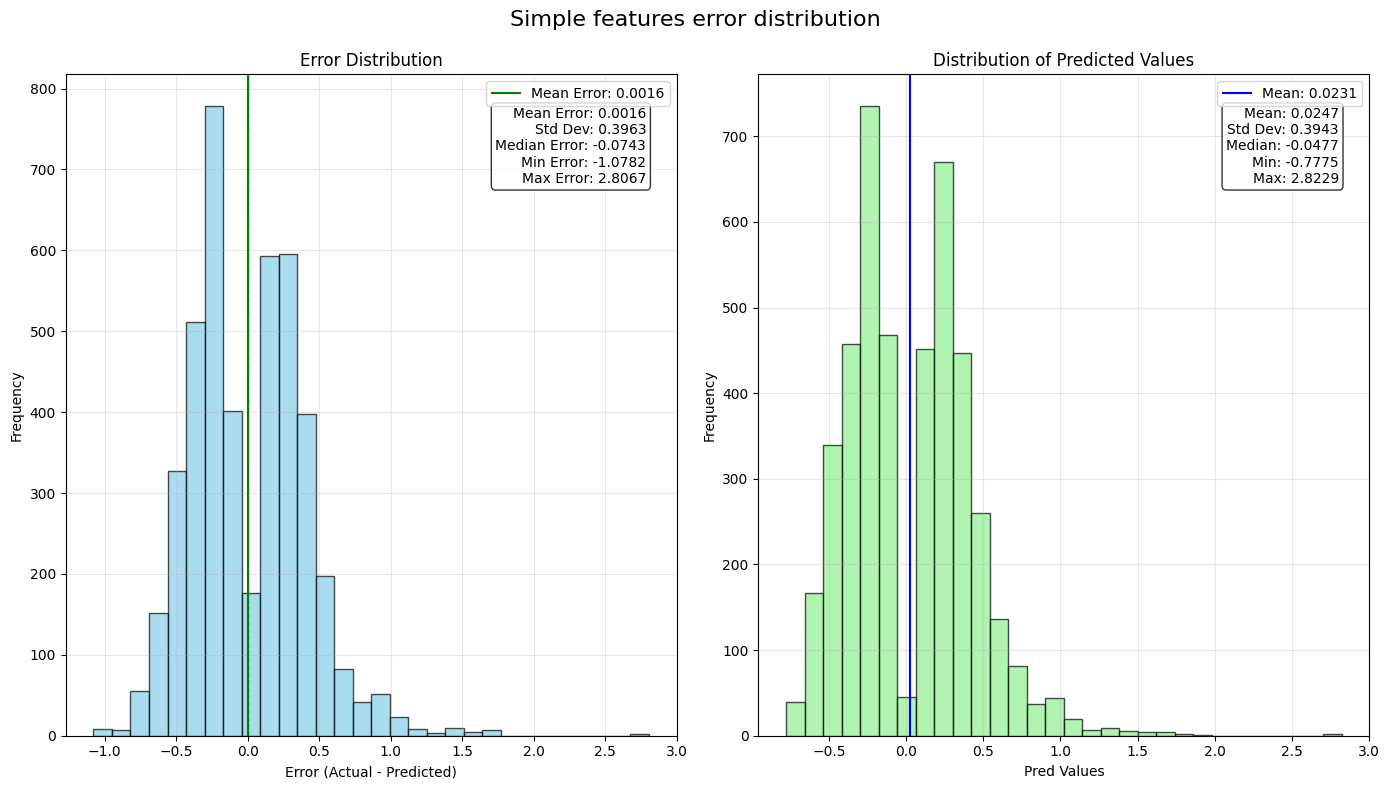

In [55]:
plot_error_distribution(y_pred_actualA, y_test_actualA, title="Simple features error distribution")


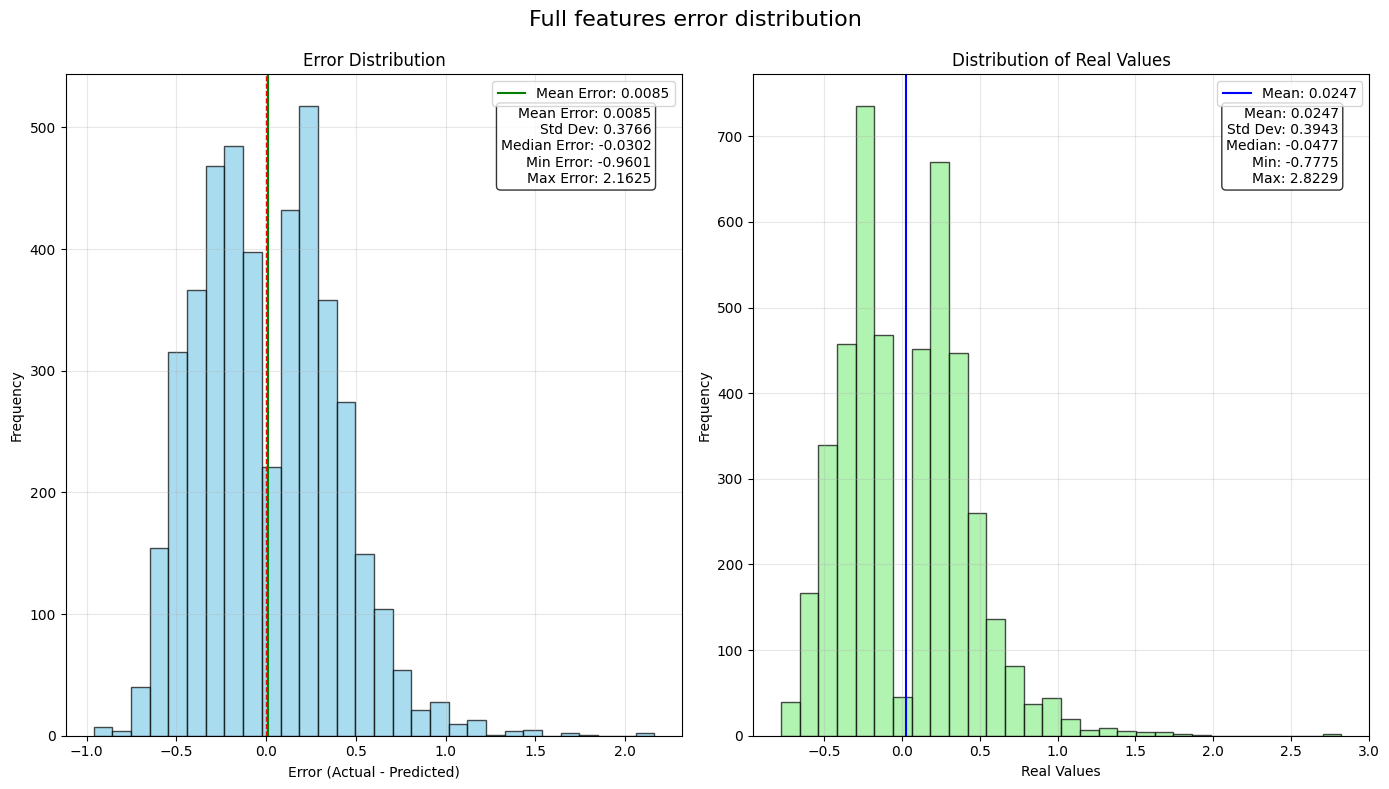

In [53]:
plot_error_distribution(y_pred_actualB, y_test_actualB, title="Full features error distribution")


In [40]:
def plot_directional_accuracy(pred, real, bins=None):
    if bins is None:
        bins = [-np.inf, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, np.inf]  # Default bins including sign


    pred = np.array(pred).flatten()
    real = np.array(real).flatten()
    
    bin_labels = [f"{bins[i]} to {bins[i+1]}" for i in range(len(bins)-1)]

    # Assign Predicted Values to Bins
    binned_data = pd.cut(pred, bins, labels=bin_labels)

    # Compute Directional Accuracy per Bin
    bin_accuracy = {}
    for bin_label in bin_labels:
        indices = (binned_data == bin_label)
        if indices.sum() > 0:  # Avoid division by zero
            correct_signs = np.sum(np.sign(pred[indices]) == np.sign(real[indices]))
            accuracy = correct_signs / indices.sum()
            bin_accuracy[bin_label] = accuracy
        else:
            bin_accuracy[bin_label] = None  # No data points in this bin

    # Remove empty bins
    bin_accuracy = {k: v for k, v in bin_accuracy.items() if v is not None}

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.bar(bin_accuracy.keys(), bin_accuracy.values(), color='skyblue')
    plt.xlabel("Predicted Value Bins")
    plt.ylabel("Directional Accuracy")
    plt.title("Directional Accuracy per Bin")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.show()

            


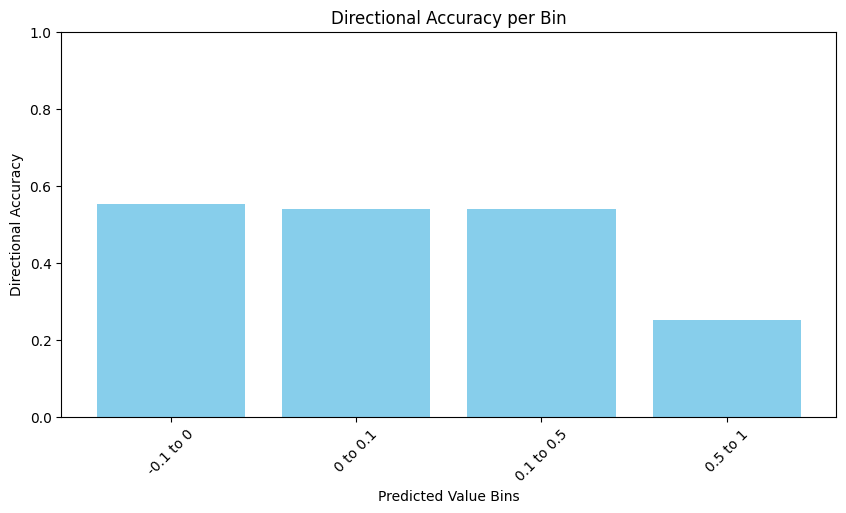

In [41]:
bins = [-np.inf, -4, -2, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 2, 4, np.inf]
plot_directional_accuracy(y_pred_actualA, y_test_actualA, bins=bins)

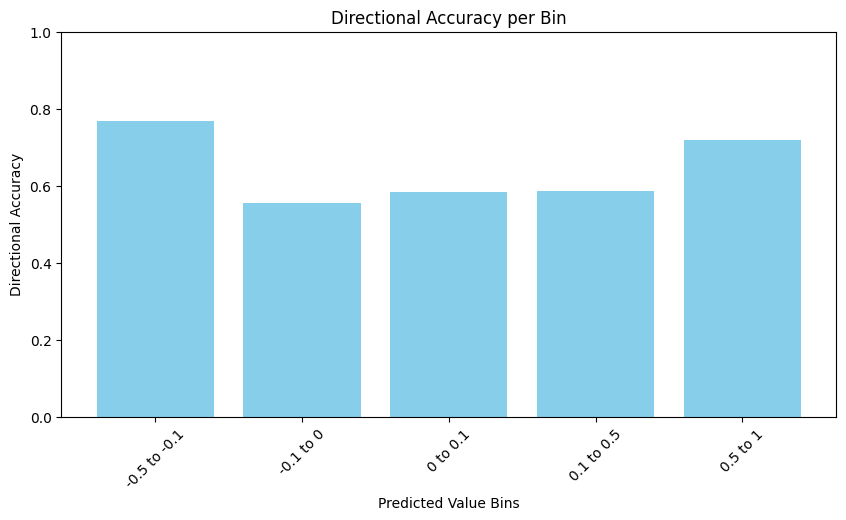

In [50]:
bins = [-np.inf, -4, -2, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 2, 4, np.inf]
plot_directional_accuracy(y_pred_actualB, y_test_actualB, bins=bins)